In [1]:
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from phasespace import Particle
from phasespace.kinematics import lorentz_vector, lorentz_boost
import tensorflow as tf
import tensorflow_probability as tfp



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
def scalar_product_4(v1, v2):
    """Calculate mass scalar for Lorentz 4-momentum.
    Arguments:
        vector: Input Lorentz momentum vector.
    """
    v0 = v1[:,3]*v2[:,3]
    
    vs = scalar_product_3(v1, v2)
    output = (v0-vs)
    
    return output

def scalar_product_3(v1, v2):
    """Calculate scalar product of two 3-vectors.
    Arguments:
        vec1: First vector.
        vec2: Second vector.
    """
    output = (v1[:,0]*v2[:,0] + v1[:,1]*v2[:,1] + v1[:,2]*v2[:,2])
    return output

def get_costheta_l(p1, p2):  
    
    num = scalar_product_3(p1, p2)

    den1= np.sqrt(scalar_product_3(p1, p1))
    den2= np.sqrt(scalar_product_3(p2, p2))
    
    costheta_l = num/(den1*den2)
    
    return costheta_l

def beta_l(q2, m):
    
    return 1-4*(np.square(m)/q2)


def lambda_function(m1, m2, q2):
    
    return np.square(np.square(m1)-np.square(m2)) -2*q2*(np.square(m1)+np.square(m2)) + np.square(q2)


In [3]:
n_events=1000000

mmu_mass = 105.0
mB_mass = 5280.0
mKst_mass = 892.0

minq=2*mmu_mass
maxq=(mB_mass-mKst_mass)

el1 = Particle('l1', mmu_mass)
el2 = Particle('l2', mmu_mass)

def modq(min_mass, max_mass, n_events):
    
        min_mass = tf.cast(min_mass, tf.float64)
        max_mass = tf.cast(max_mass, tf.float64)

        min_mass = tf.broadcast_to(min_mass, shape=(n_events,))
        
        modq_mass = tfp.distributions.Uniform(low=min_mass, high=max_mass).sample()
        
        return modq_mass
    
q=Particle('q', modq).set_children(el1, el2)
Kst = Particle('Kst', mKst_mass)

B = Particle('B', mB_mass).set_children(Kst, q)

z=np.array([[0.,0.,1.,0.] for i in range(n_events)])
weights_np, particles_np = B.generate(n_events=n_events)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
z.shape

(1000000, 4)

105.0000404384508 5279.999786972526


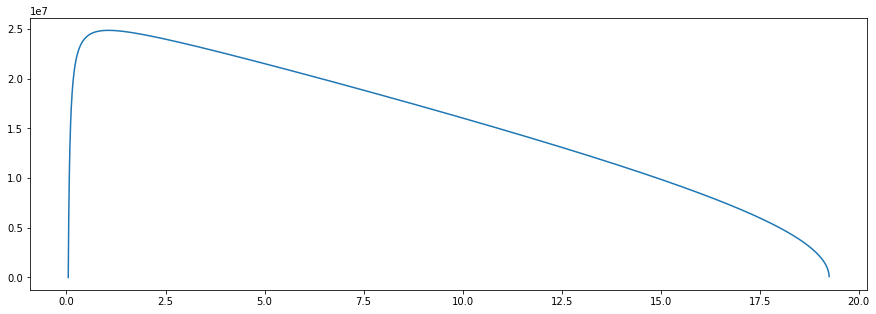

In [5]:
Kst=particles_np['Kst']
l1 =particles_np['l1']
l2 =particles_np['l2']
q_np=particles_np['q']
q2_array=scalar_product_4(q_np,q_np)
q2_range=np.arange(q2_array.min(), q2_array.max(),1000)
print(np.sqrt(q2_array.min()/4), np.sqrt(q2_array.max())+mKst_mass)

val=np.sqrt(lambda_function(mB_mass, mKst_mass, q2_range))*beta_l(q2_range, mmu_mass)
plt.plot(q2_range/1e6, val);
fig=plt.gcf()
fig.set_size_inches(15,5)

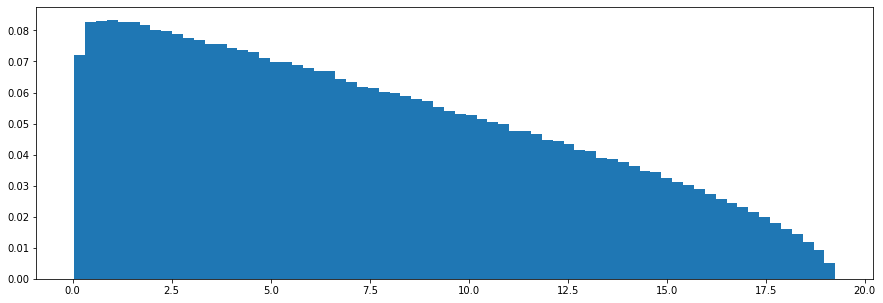

In [6]:
plt.hist(q2_array/1e6,bins=70, weights=weights_np,density=True);
fig=plt.gcf()
fig.set_size_inches(15,5);

In [7]:
def lorentz_boost(fvector_to_boost, boost_vector):
    
    boost_vector_spatial=-boost_vector[:,0:3]
    boost_vector_time_component=boost_vector[:,3].reshape(-1,1)
    
    beta = boost_vector_spatial/boost_vector_time_component
    beta2 = scalar_product_3(beta,beta).reshape(-1,1)
    
    gamma = 1./np.sqrt(1.-beta2)
    gamma_ = (gamma-1.)/beta2
    
    ve = fvector_to_boost[:,3].reshape(-1,1)
    vp = fvector_to_boost[:,0:3]
    
    ve2 = gamma*(ve + scalar_product_3(vp,beta).reshape(-1,1))
    vp2 = vp + (gamma*ve + gamma_*scalar_product_3(vp, beta).reshape(-1,1))*beta
    
    boosted_fvector=np.concatenate([vp2,ve2],axis=1)
    return boosted_fvector

In [8]:
p1_q = lorentz_boost(l1, q_np)

In [9]:
p2_q = lorentz_boost(l2, q_np)

In [10]:
(p1_q[:,0:3]+p2_q[:,0:3]).mean()<1e-10, np.sqrt(scalar_product_4(p1_q,p1_q)).mean()-105<1e-10, np.sqrt(scalar_product_4(p2_q,p2_q)).mean()-105<1e-10

(True, True, True)

In [11]:
cos_theta_l_np=get_costheta_l(p1_q,z)

In [15]:
def dGamma_weights():
    
    Kst=particles_np['Kst']
    l1 =particles_np['l1']
    l2 =particles_np['l2']
    q=particles_np['q']
    
    
    q2 = scalar_product_4(q,q)
    modq = np.sqrt(q2)
    
    l1_q = lorentz_boost(l1, q)
    l2_q = lorentz_boost(l2, q)
    

    cos_theta_l=get_costheta_l(l1_q,z)

    #G_weights = 1/(1-cos_theta_l*(mmu_mass)**2)
    #print(cos_theta_l)
    G_weights = (q2/(1-beta_l(q2,mmu_mass))) #*(1+cos_theta_l+cos_theta_l**2)
    
    return G_weights
    

In [16]:
dGamma=dGamma_weights()

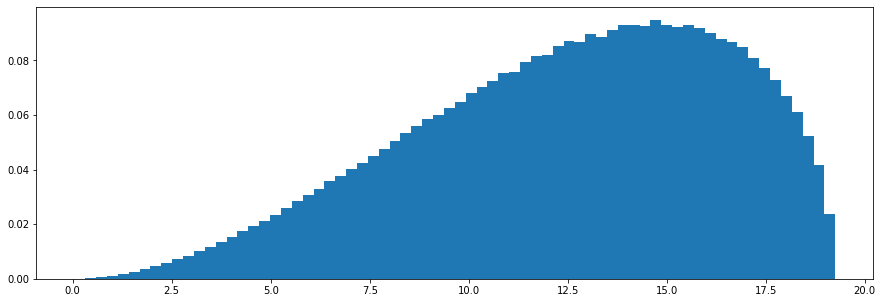

In [17]:
plt.hist(q2_array/1e6,bins=70, weights=weights_np*dGamma,density=True);
fig=plt.gcf()
fig.set_size_inches(15,5);

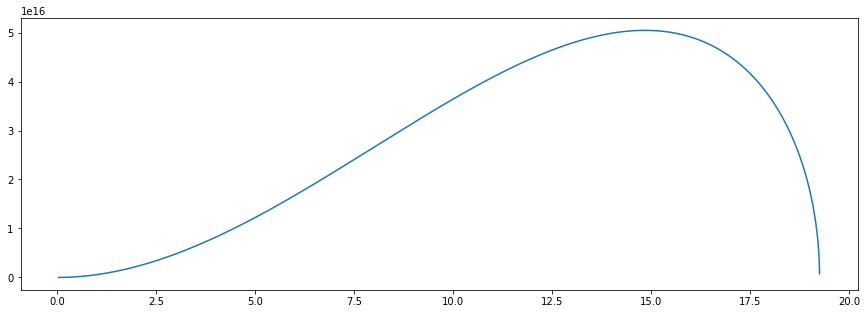

In [19]:
q2_array=scalar_product_4(q_np,q_np)
q2_range=np.arange(4*mmu_mass**2, (mB_mass-mKst_mass)**2,1000)

val=(q2_range/(1-beta_l(q2_range,mmu_mass)))*np.sqrt(lambda_function(mB_mass, mKst_mass, q2_range))*beta_l(q2_range, mmu_mass)
plt.plot(q2_range/1e6, val);
fig=plt.gcf()
fig.set_size_inches(15,5)

In [ ]:
#class dGamma(zfit.pdf.ZPDF):
#    
#    _PARAMS = ['ml','mB','mKst']
#    _N_OBS = 16
#
#    def _unnormalized_pdf(self, x):
#        
#        ml = self.params['ml']
#        mB = self.params['mB']
#        mKst = self.params['mKst']
#        
#        pKstx, pKsty, pKstz, pKstE, qx, qy, qz, qE, p1x, p1y, p1z, p1E, p2x, p2y, p2z, p2E = x.unstack_x()
#        
#        pKst = np.array([pKstx, pKsty, pKstz, pKstE])
#        q = np.array([qx, qy, qz, qE])
#        p1 = np.array([p1x, p1y, p1z, p1E])
#        p2 = np.array([p2x, p2y, p2z, p2E])
#        
#        #z = tf.expand_dims(tf.stack([0., 0., 1., 0.],         axis=0), axis=0)
#        #z = [0.,0.,1.]
#        q=p1+p2
#        q2=scalar_product_4(q,q)
#        modq = ztf.sqrt(q2)
#
#        #q_in_q_rf = lorentz_vector([0.,0.,0.], modq)
#        #p1q = lorentz_boost(p1, q_in_q_rf)
#        #costheta_l= get_costheta_l(p1, z)
#        
#        pdf= lambda_function(mB, mKst, q2)*beta_l(q2, ml)
#        return pdf
#

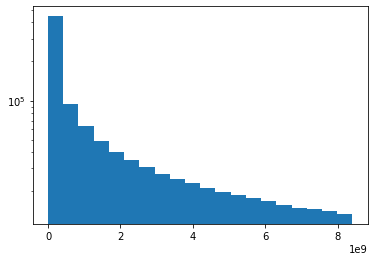

In [138]:
plt.hist(dGamma,bins = 20, log=True);